In [1]:
import tensorflow as tf
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from tensorflow.keras import layers, models
import pickle
import json

In [2]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("GPU not found. Go to Runtime > Change runtime type > GPU")

GPU detected: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/MLHD_Project/Data/processed_dataset.zip" -d "/content"

In [5]:
PROJECT_DIR = "/content/drive/MyDrive/MLHD_Project"
PROCESSED_DATA_DIR = "/content/processed_dataset"

with open(PROJECT_DIR + "/Data/class_weights.pkl", "rb") as f:
    class_weights = pickle.load(f)

with open(PROJECT_DIR + "/Data/label_to_index.pkl", "rb") as f:
    label_to_index = pickle.load(f)

with open(PROJECT_DIR + "/Data/index_to_label.pkl", "rb") as f:
    index_to_label = pickle.load(f)

In [6]:
def load_dataset(split_path, label_to_index, input_shape=(40, 101), shuffle=True):
    data = []
    labels = []

    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if not fname.endswith(".npy"):
                continue

            file_path = os.path.join(label_path, fname)
            spectrogram = np.load(file_path).astype(np.float32)

            # Ensure shape matches
            if spectrogram.shape != input_shape:
                print(f"Skipping {file_path} due to shape mismatch: {spectrogram.shape}")
                continue

            data.append(spectrogram)
            labels.append(label_to_index[label])

    data = np.array(data)[..., np.newaxis]  # Add channel dim
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))

    return dataset

In [7]:
train_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "train"), label_to_index)
val_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "val"), label_to_index, shuffle=False)
test_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "test"), label_to_index, shuffle=False)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
def baseline_cnn(input_shape=(40, 101, 1), num_classes = len(label_to_index)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = baseline_cnn(input_shape=(40, 101, 1), num_classes=len(label_to_index))
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - accuracy: 0.0435 - loss: 3.5699 - val_accuracy: 0.1439 - val_loss: 3.2264
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.1043 - loss: 3.3266 - val_accuracy: 0.1990 - val_loss: 2.9972
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.1428 - loss: 3.1450 - val_accuracy: 0.2863 - val_loss: 2.6843
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.1804 - loss: 2.9619 - val_accuracy: 0.3465 - val_loss: 2.4194
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.2211 - loss: 2.8022 - val_accuracy: 0.3998 - val_loss: 2.2169
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.2581 - loss: 2.6356 - val_accuracy: 0.4658 - val_loss: 1.9958
Epoch 7/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.3016 - loss: 2.4340 - val_accuracy: 0.5410 - val_loss: 1.6910
Epoch 8/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.3400 -

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7985 - loss: 0.7023

Test accuracy: 0.7863
Test loss: 0.7551


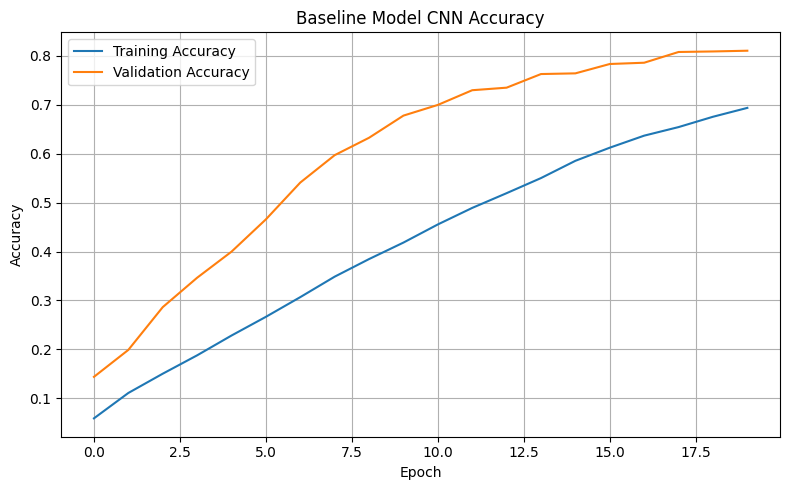

In [11]:
history_dict = history.history
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/baseline_cnn_accuracy.png")
plt.show()

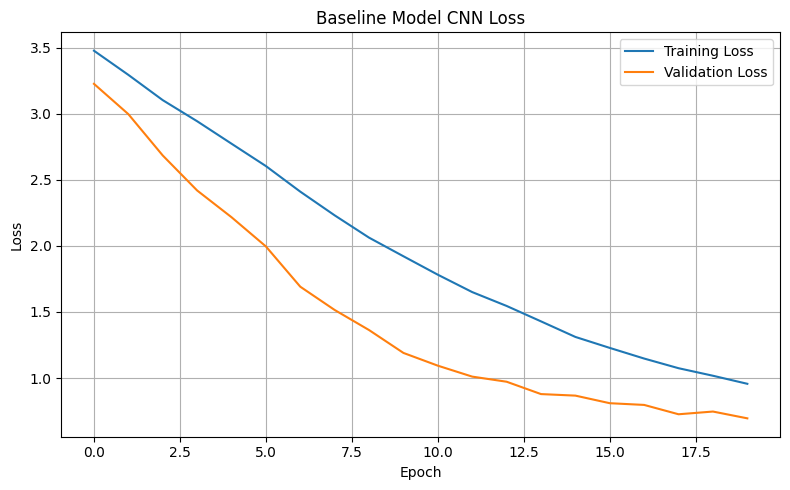

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Baseline Model CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/baseline_cnn_loss.png")
plt.show()

In [13]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8140 - loss: 0.6723

Validation accuracy: 0.8105
Validation loss: 0.6947


In [14]:
model_name = "baseline_cnn"
drive_dir = f"/content/drive/MyDrive/MLHD_Project/{model_name}"
os.makedirs(drive_dir, exist_ok=True)

model.save(os.path.join(drive_dir, f"{model_name}_model.keras"))
model.save_weights(os.path.join(drive_dir, f"{model_name}.weights.h5"))

history_path = os.path.join(drive_dir, "training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

metadata = {
    "model_name": model_name,
    "epochs": len(history.history["accuracy"]),
    "final_train_acc": round(history.history["accuracy"][-1], 4),
    "final_val_acc": round(history.history["val_accuracy"][-1], 4),
    "input_shape": model.input_shape,
    "output_shape": model.output_shape,
    "num_params": model.count_params(),
}
metadata_path = os.path.join(drive_dir, f"metadata_{model_name}.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 99, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 38, 99, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 36, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 97, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,078,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,304,811 (81.27 MB)

 Trainable params: 7,101,539 (27.09 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 14,203,080 (54.18 MB)